# INTRODUZIONE AL PROBLEMA DELLA CLASSIFICAZIONE

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, \
precision_score,recall_score, accuracy_score,f1_score, roc_auc_score, auc

import seaborn as sns

### Load dataset

In [29]:
# let's load the data
url = 'https://raw.githubusercontent.com/giandopal/Artificial-Intelligence-with-Python/main/data/Default.csv'
default = pd.read_csv(url, usecols=[1,2,3,4])

In [32]:
default.iloc[:,1]

0        No
1       Yes
2        No
3        No
4        No
       ... 
9995     No
9996     No
9997     No
9998     No
9999    Yes
Name: student, Length: 10000, dtype: object

In [5]:
# we have 10000 samples. about 400 KB of memory. Not too much
default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [6]:
default.head(10)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
5,No,Yes,919.588530,7491.558572
6,No,No,825.513331,24905.226578
7,No,Yes,808.667504,17600.451344
8,No,No,1161.057854,37468.529288
9,No,No,0.000000,29275.268293


## Il Dataset
- Abbiamo una feature 'continua': **annual income** (reddito annuale della persona) 
- Abbiamo una feature 'continua': **card balances** (saldo mensile medio della carta di credito)
- Abbiamo una feature 'qualitativa' (categorical): **student** (YES/NO) (se il creditore è uno studente)
- Abbiamo una feature 'qualitativa' : **default** (YES/NO) (se il creditore non ha saldato il conto della carta di credito)

Il nostro obiettivo è costruire un modello di supervised learning che ci permetta di prevedere se il creditore andrà in default (non riuscirà a saldare il conto carta) sulla base del reddito del creditore e del saldo medio che ha sulla carta di credito

l dataset è lo stesso utilizzato nel libro Introduction to Statistical Learning- Hastie, Tibshirani - capitolo 4, pg 129.

## Come trattiamo le colonne 'Qualitative'? 
## Notiamo che le features possono assumere solo i valori YES o NO. 
## Considero pertanto la seguente associazione: NO = 0, YES=1 e sostituisco i valori nelle rispettive colonne

In [40]:
# Voglio creare due classi, una per la feature default e una per la feature student

# Note: factorize() returns two objects: a label array (1 and 0) and an array with the unique values.
# We are only interested in the first object. 
# We create 2 more columns on our dataset with the "flags" 0 and 1 for Student-Non Student and Default- Non Default

default['default2'] = default.default.factorize()[0]
default['student2'] = default.student.factorize()[0]
default.head(3)

,default,student,balance,income,default2,student2
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0


In [41]:
default[default.default2 == 0]

,default,student,balance,income,default2,student2
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0
3,No,No,529.250605,35704.493935,0,0
4,No,No,785.655883,38463.495879,0,0
...,...,...,...,...,...,...
9995,No,No,711.555020,52992.378914,0,0
9996,No,No,757.962918,19660.721768,0,0
9997,No,No,845.411989,58636.156984,0,0
9998,No,No,1569.009053,36669.112365,0,0


In [42]:
# Take a fraction of the samples where target value (default) is 'no'
default_no = default[default.default2 == 0].sample(frac=0.10)
# Take all samples  where target value is 'yes'
default_yes = default[default.default2 == 1]

# append the default YES to the end of the sample of DEFAULT NO
default_ = default_no.append(default_yes)

/tmp/ipykernel_120255/3719421832.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  default_ = default_no.append(default_yes)


In [10]:
default_.shape

(1300, 6)

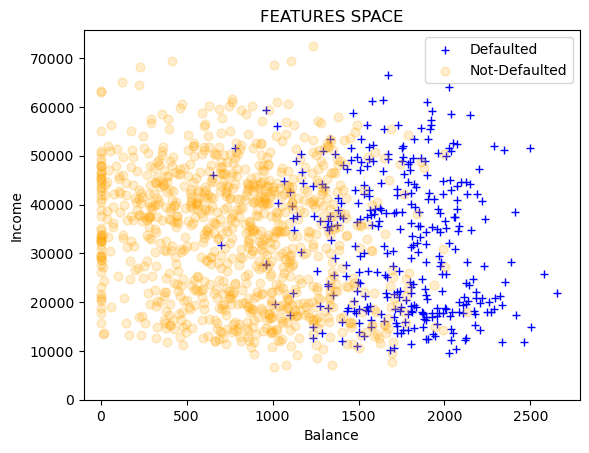

In [11]:

plt.scatter(default_[default_.default == 'Yes'].balance, default_[default_.default == 'Yes'].income, \
    s=40, c='blue', marker='+',linewidths=1, label="Defaulted")

plt.scatter(default_[default_.default == 'No'].balance, default_[default_.default == 'No'].income, \
    s=40, c='orange', marker='o',linewidths=1, alpha=.2,label="Not-Defaulted")

plt.legend()
plt.title('FEATURES SPACE')
plt.ylim(ymin=0)
plt.ylabel('Income')
plt.xlim(xmin=-100)
plt.xlabel('Balance')
plt.show()


## Dalla figura possiamo osservare che la feature "Income" è meno importante della feature "Balance" per determinare chi è andato in default

# Proviamo a semplificare il problema e consideriamo solo una feature: il Balance
(nel caso di una sola feature il problema si chiama BINARY CLASSIFICATION PROBLEM)


Plottiamo i dati

In [44]:
x_train = default['balance'].values
y_train = default['default2'].values

In [45]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

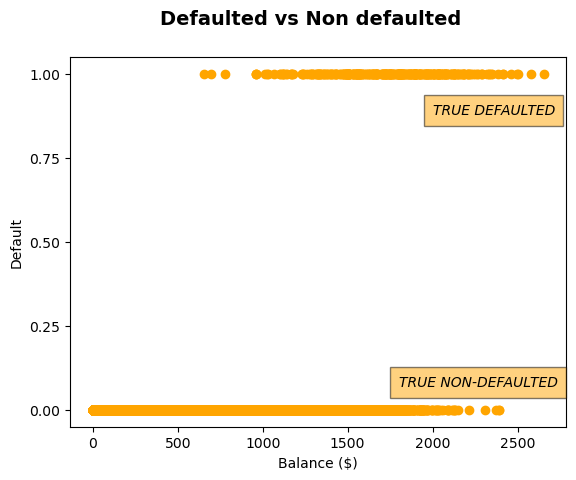

In [46]:
fig = plt.figure()
ax = fig.add_subplot()
# Set titles for the figure and the subplot respectively
fig.suptitle('Defaulted vs Non defaulted', fontsize=14, fontweight='bold')
# true value
ax.scatter(x_train,y_train, c='orange')

ax.text(2000, 0.88, 'TRUE DEFAULTED', style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 6})
ax.text(1800, 0.07, 'TRUE NON-DEFAULTED', style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 6})

ax.set_ylabel('Default');
ax.set_xlabel('Balance ($)');
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.]);

# Il nostro è un problema di classificazione. 
Sulla base del valore del Balance vogliamo classificare se il debitore andrà in default oppure no. Utilizzeremo un un modello **Logistic regression**

Abbiamo due classi - 0 (NON DEFAULT) e 1 (DEFAULT)

Stiamo cercando una relazione che lega la PROBABILITA' $Pr(Y|X)$ alla feature $X$. Ricordiamo che Y è costituito da soli 2 valori: {0,1}

Nel nostro modello di **logistic regression** scegliamo: $P(Y=1|X) = \sigma (w_0 + w_1x)$

dove $\sigma$ è il LOGISTIC SIGMOID $1/(1+exp(-x))$ 

Quindi $P(Y=1|X) = \frac {1}{1+e^{(-(w_0 + w_1x))}}$ 


Ricordiamo che $P(Y=0|X) = 1 - P(Y=1|X)$

Ora riflettiamo sulla $P(Y=1|X)$.

Una volta effettuato il training il nostro modello e trovati $w_0,w_1$, $P(Y=1|X)$ è il predittore probabilistico che stiamo cercando.

Come funziona questa predittore che abbiamo trovato?

Se utilizziamo come input del predictor una specifica x di training posso stimare la probabilità che tale input appartenga alla 0 o 1. 

facciamo però attenzione perchè ora abbiamo un PREDICTORE PROBABILISTICO MA DOBBIAMO ANCORA PASSARE ATTRAVERSO UN PROCESSO DECISIONALE. Dobbiamo fissare una SOGLIA sulla nostra probabilità, al di sopra della quale decidiamo di assegnare l'input alla classe 1 o 0.

Per esempio. Supponiamo che per un dato X si abbia $P(Y=1|X) =0.65$. Quindi il predittore dice che sulla base del modello adattato (quindi sulla base delle informazioni che ho usato per addestrarlo) abbiamo una probabilità del 65% che quella caratteristica produca una classe 1 e il 35%, una classe 0. Ora, quale decisione possiamo prendere? Classe 1? Supponiamo di fissare come soglia 0,5. Questo significa che se il mio predittore ci da una probabilità superiore al 50% allora classifico il dato di input come 1 altrimenti 0. 

Se invece fisso la soglia a 0,75, allora nel caso in cui l'ipotesi function mi da 0.65, classifico l'input nella classe 0

Il processo decisionale è quindi sempre decisivo.

Fai attenzione che poiché la relazione tra $P(Y=1|X)$ e X NON È LINEARE.


In [33]:
x_train.shape

(1300,)

In [47]:
# Let's try with one feature - Balance
x_train_ = x_train.reshape(-1,1) 
# Crea un'istanza del modello di logistic regression
model = LogisticRegression()

# Addestra il modello sui dati di training
model.fit(x_train_, y_train)

# Calcoliamo le probabilità P(y=1 | x)
y_pred = model.predict_proba(x_train_)

# Stampa le predizioni
print(y_pred[:,0])

[0.99869432 0.9978874  0.99140525 ... 0.99753348 0.88324037 0.99992855]


Text(300, 0.6, 'Predicted Probability P(y=1|x)')

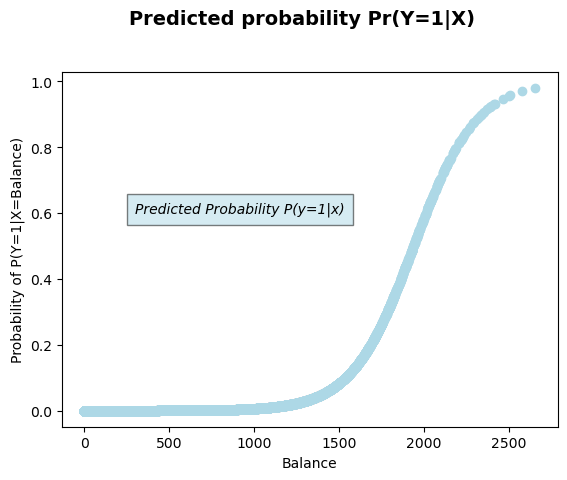

In [48]:
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
fig.suptitle('Predicted probability Pr(Y=1|X)', fontsize=14, fontweight='bold')

# plot predicted value
ax.scatter(x_train, y_pred[:,1], color='lightblue')

ax.set_ylabel('Probability of P(Y=1|X=Balance)');
ax.set_xlabel('Balance');
ax.text(300, 0.60, 'Predicted Probability P(y=1|x)', style='italic', bbox={'facecolor': 'lightblue', 'alpha': 0.5, 'pad': 6})

/tmp/ipykernel_120255/546439122.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  axs[1].plot([1520,1520],[0,1], 'g--', c='blue') # class boundary


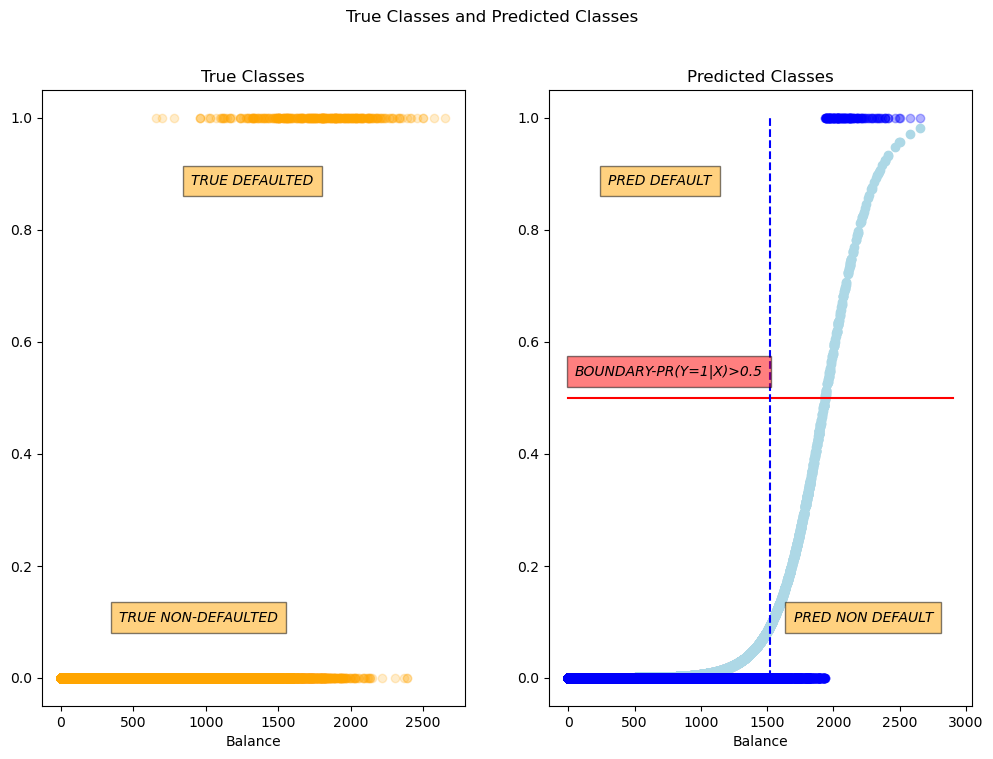

In [49]:
fig, axs = plt.subplots(1,2, figsize=(12, 8))
axs = axs.flatten()

y_pred_class = model.predict(x_train_)
# Plotta i tre grafici
axs[1].scatter(x_train, y_pred[:,1], color='lightblue')
axs[1].scatter(x_train, y_pred_class, color='blue', alpha= 0.3)
axs[1].plot([0,2900],[0.5,0.5], c='red') # decision boundary
axs[1].plot([1520,1520],[0,1], 'g--', c='blue') # class boundary
axs[1].text(300, 0.88, 'PRED DEFAULT', style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 6})
axs[1].text(1700, 0.1, 'PRED NON DEFAULT', style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 6})
axs[1].text(50, 0.54, 'BOUNDARY-PR(Y=1|X)>0.5', style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 6})


axs[0].scatter(x_train, y_train, color='orange', alpha=0.2)
axs[0].text(900, 0.88, 'TRUE DEFAULTED', style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 6})
axs[0].text(400, 0.1, 'TRUE NON-DEFAULTED', style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 6});

# Aggiunge etichette agli assi e alla figura
fig.suptitle('True Classes and Predicted Classes')
axs[0].set_xlabel('Balance')
axs[0].set_title("True Classes")
axs[1].set_xlabel('Balance')
axs[1].set_title("Predicted Classes")

# Mostra la figura
plt.show()

/tmp/ipykernel_120255/3875277917.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax.plot([1520,1520],[0,1], 'g--', c='blue') # class boundary


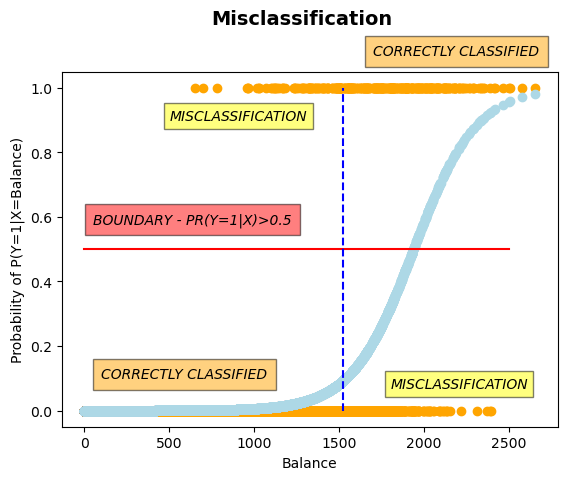

In [50]:
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
fig.suptitle('Misclassification', fontsize=14, fontweight='bold')

# plot the true value
ax.scatter(x_train, y_train, color='orange')

# plot predicted value
ax.scatter(x_train, y_pred[:,1], color='lightblue')

ax.plot([0,2500],[0.5,0.5], c='red') # decision boundary
ax.plot([1520,1520],[0,1], 'g--', c='blue') # class boundary

ax.set_ylabel('Probability of P(Y=1|X=Balance)');
ax.set_xlabel('Balance');
ax.text(50, 0.58, 'BOUNDARY - PR(Y=1|X)>0.5', style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 6})
ax.text(1700, 1.1, 'CORRECTLY CLASSIFIED', style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 6})
ax.text(100, 0.1, 'CORRECTLY CLASSIFIED', style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 6});
ax.text(500, 0.9, 'MISCLASSIFICATION', style='italic', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 4});
ax.text(1800, 0.07, 'MISCLASSIFICATION', style='italic', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 4});


Ora che ho la mia prediction come faccio a sapere se ho fatto un buon lavoro
# Uso la CONFUSION MATRIX


![CONFUSION MATRIX](https://github.com/giandopal/Artificial-Intelligence-with-Python/blob/main/fig/conf-mat.png?raw=true)

# ESEMPIO

![es](https://github.com/giandopal/Artificial-Intelligence-with-Python/blob/main/fig/es-conf.png?raw=true)

## here a summary

![conf1](https://github.com/giandopal/Artificial-Intelligence-with-Python/blob/main/fig/conf1.png?raw=true)

![conf2](https://github.com/giandopal/Artificial-Intelligence-with-Python/blob/main/fig/conf2.png?raw=true)

![conf3](https://github.com/giandopal/Artificial-Intelligence-with-Python/blob/main/fig/conf3.png?raw=true)


TN	FP
FN	TP


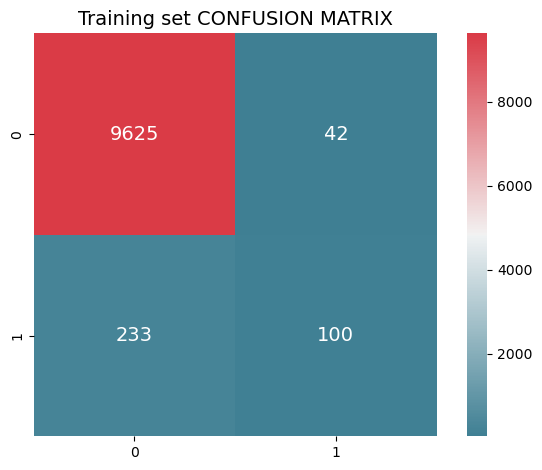

Precision = 0.3003
Recall= 0.7042
F1-score= 0.4211
Accuracy = 0.9725


In [51]:
#Generate confusion matrixes and print main indicators
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in [['TN', 'FP'],['FN','TP']]]))

#generate confusion matrixes
cm_train = confusion_matrix(y_train, y_pred_class)

hm = sns.heatmap(cm_train,cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 14},cmap = sns.diverging_palette(220, 10, as_cmap=True))
plt.title('Training set CONFUSION MATRIX', fontsize=14)

plt.tight_layout()
plt.show()

print('Precision = {0:5.4f}'.format(precision_score(y_pred_class,y_train)))
print('Recall= {0:5.4f}'.format(recall_score(y_pred_class,y_train)))
print('F1-score= {0:5.4f}'.format(f1_score(y_pred_class,y_train)))
print('Accuracy = {0:5.4f}'.format(accuracy_score(y_pred_class,y_train)))

# ORA PROVA TU

Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage

Il dataset contiene 768 istanze e 8 attributi, tra cui:

    Pregnancies: il numero di gravidanze della paziente
    Glucose: il livello di glucosio nel plasma a digiuno della paziente
    BloodPressure: la pressione sanguigna diastolica della paziente
    SkinThickness: lo spessore cutaneo del tricipite della paziente
    Insulin: la quantità di insulina nel sangue della paziente
    BMI: l'indice di massa corporea della paziente
    DiabetesPedigreeFunction: una stima della predisposizione genetica al diabete della paziente
    Outcome: se la paziente ha il diabete (1) o meno (0)

In [24]:
url = 'https://raw.githubusercontent.com/giandopal/Artificial-Intelligence-with-Python/main/data/diabetes.csv'
# Carica il dataset
diabetes = pd.read_csv(url)

In [26]:
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


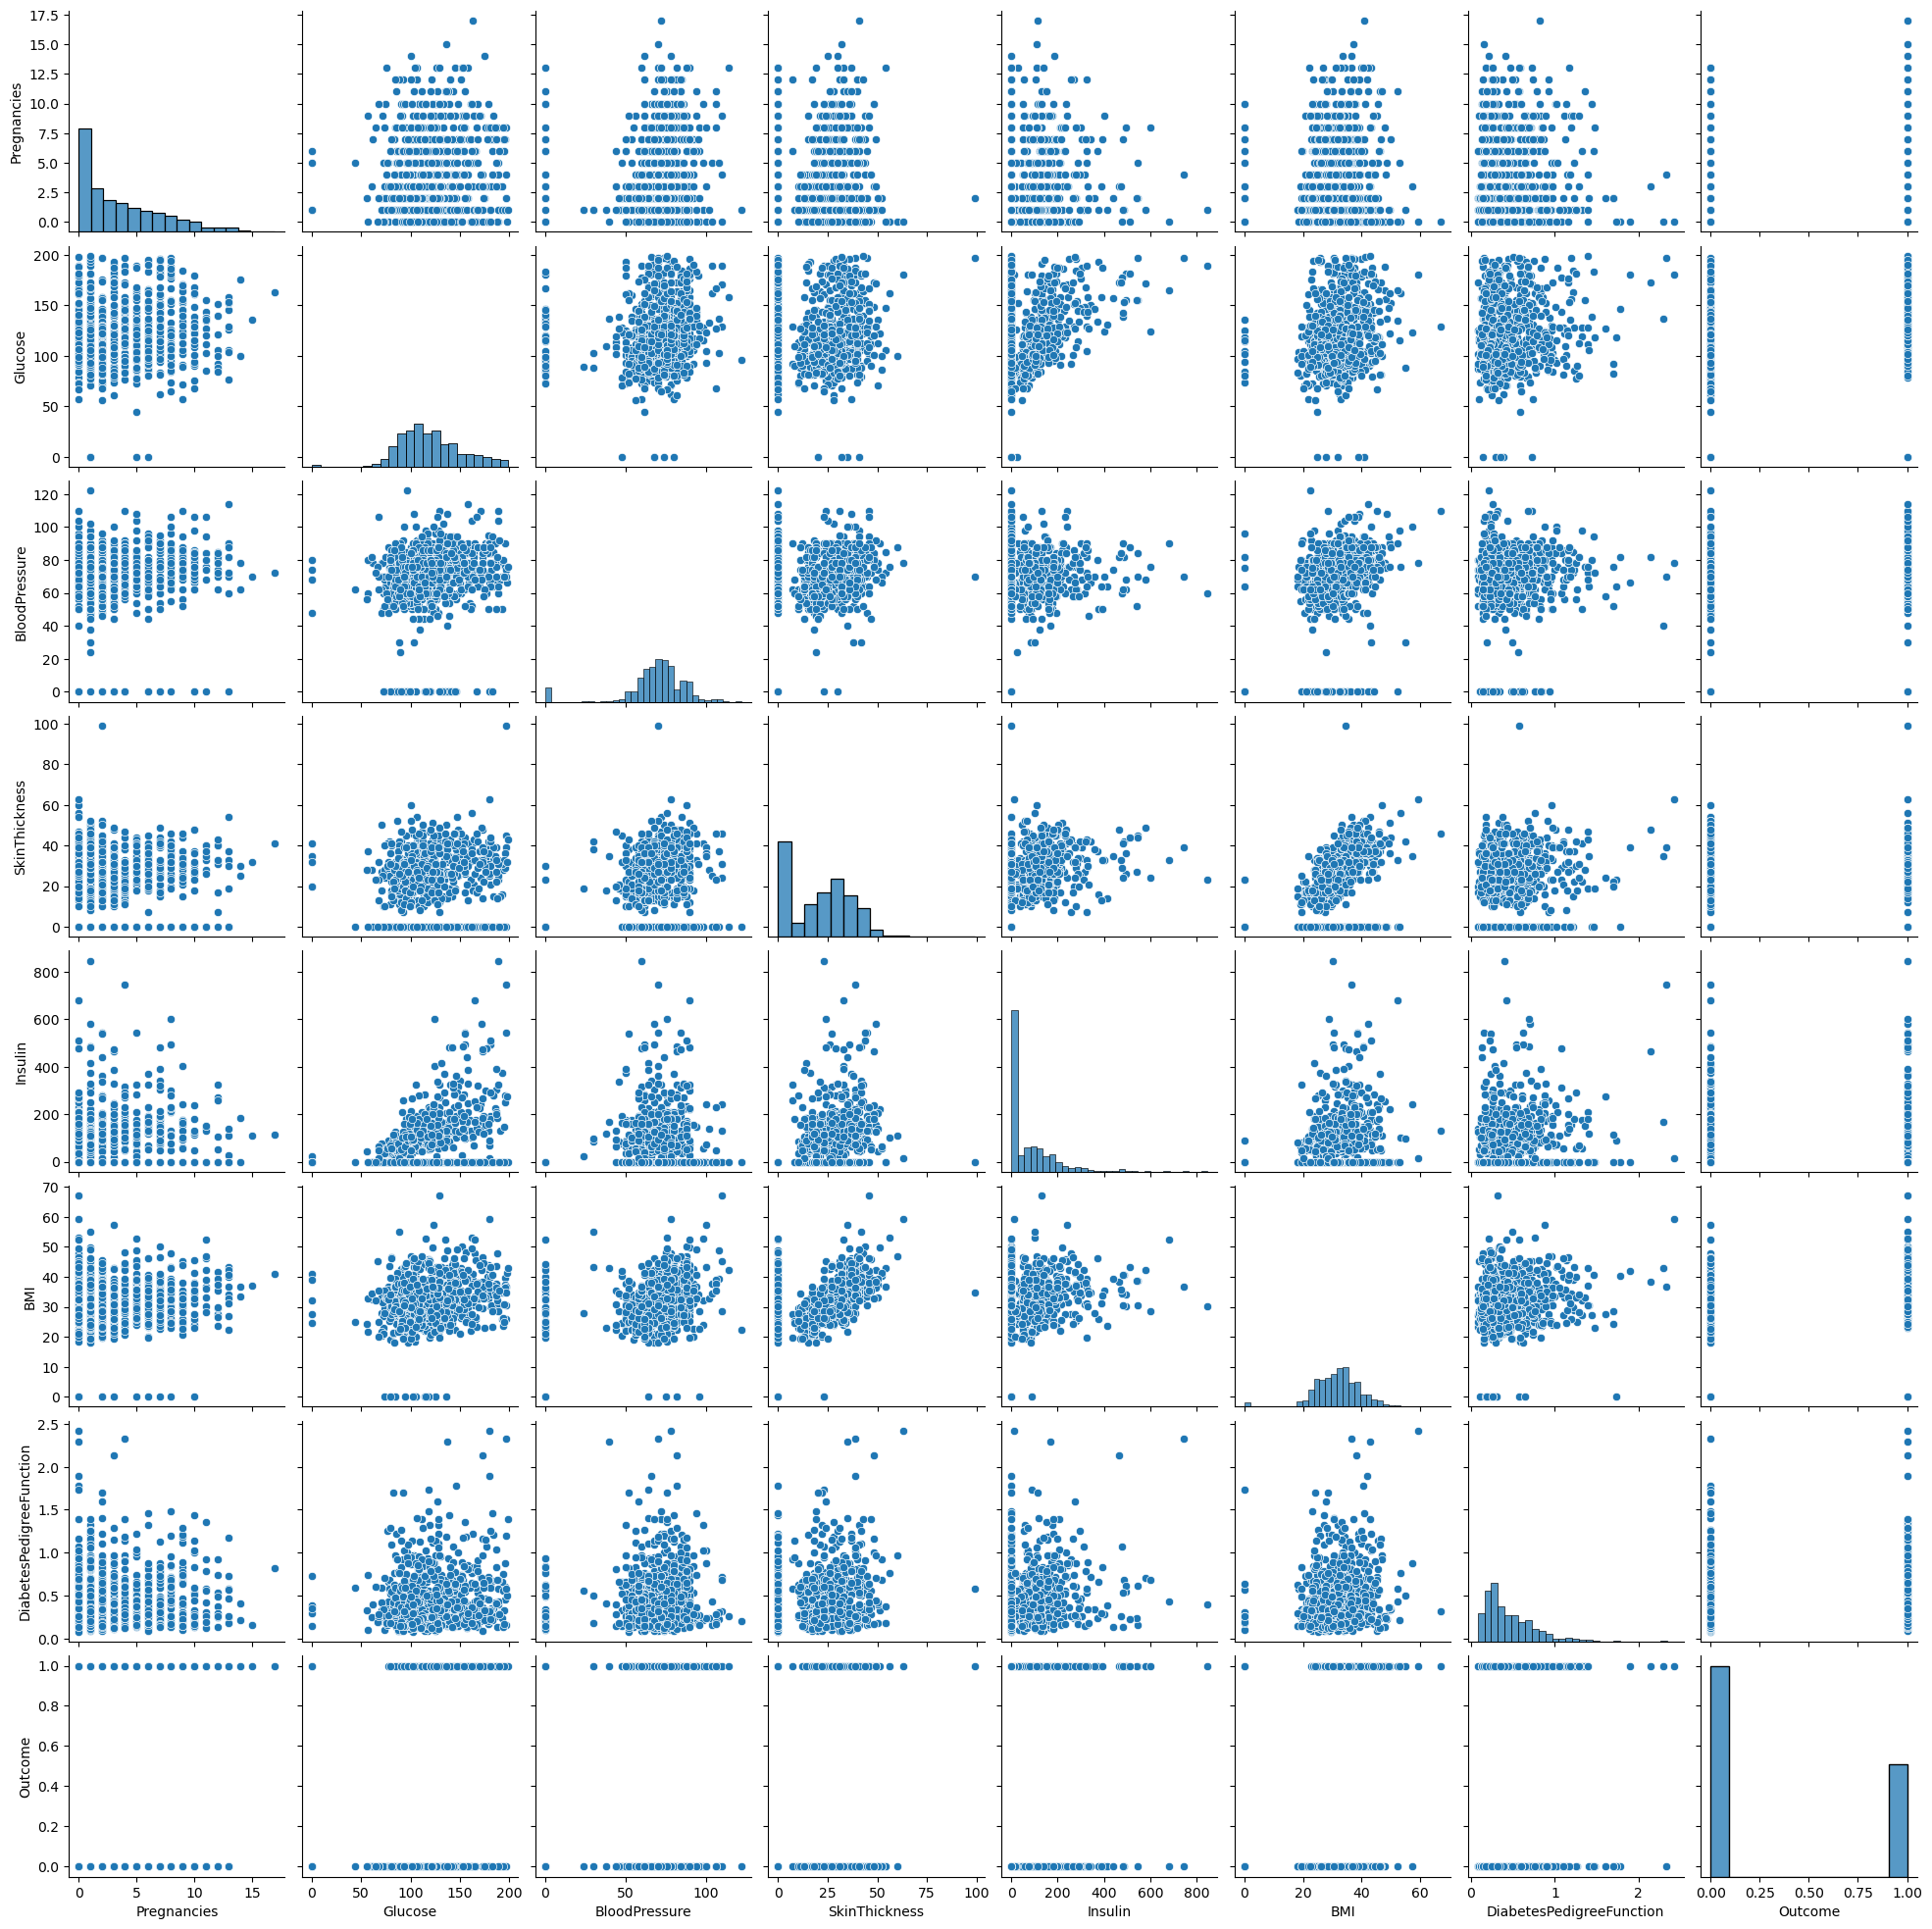

In [27]:
names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Outcome']
sns.pairplot(diabetes[names]);

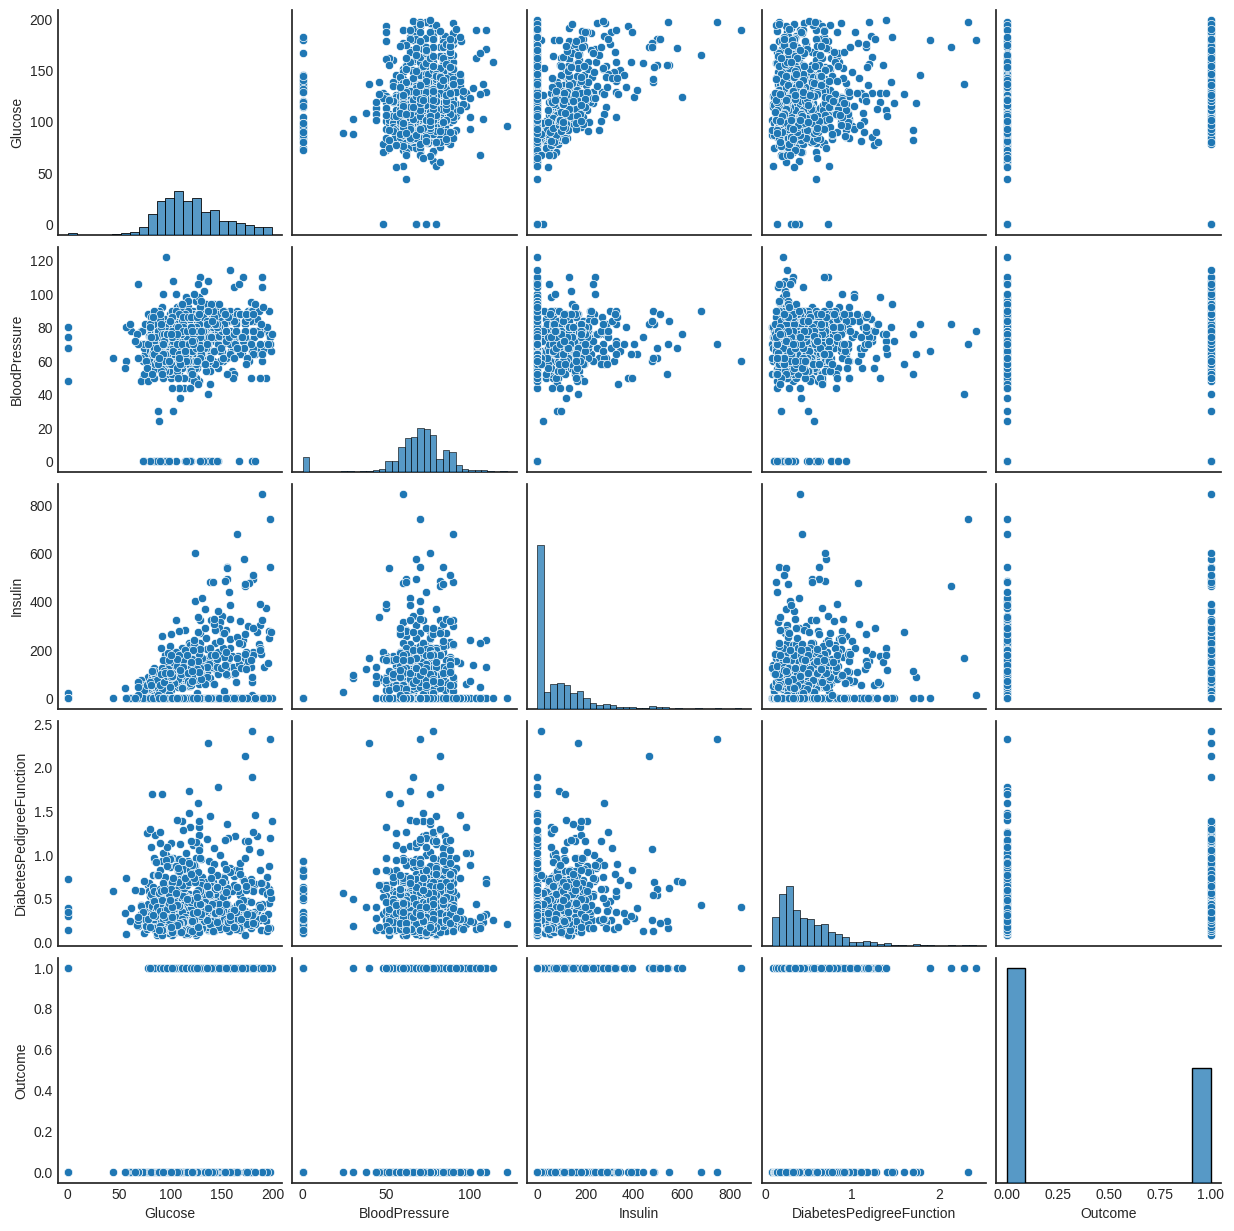

In [229]:
names = ['Glucose', 'BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'Outcome']
sns.pairplot(diabetes[names]);

In [242]:

# Dividiamo il dataset in features e target variable
x = diabetes.drop('Outcome', axis=1)
x_train_diabetes = diabetes['Glucose'].values.reshape(-1,1)
y_train_diabetes = diabetes['Outcome'].values

# Creiamo un'istanza di Logistic Regression
logreg = LogisticRegression()

# Addestriamo il modello sui dati di training
logreg.fit(x_train_diabetes, y_train_diabetes)

# Facciamo le predizioni sul test set
y_pred_diabetics = logreg.predict(x_train_diabetes)


In [243]:
print('Precision = {0:5.4f}'.format(precision_score(y_pred_diabetics,y_train_diabetes)))
print('Recall= {0:5.4f}'.format(recall_score(y_pred_diabetics,y_train_diabetes)))
print('F1-score= {0:5.4f}'.format(f1_score(y_pred_diabetics,y_train_diabetes)))
print('Accuracy = {0:5.4f}'.format(accuracy_score(y_pred_diabetics,y_train_diabetes)))

Precision = 0.4851
Recall= 0.6952
F1-score= 0.5714
Accuracy = 0.7461


# Cosa succede se cambiamo il DECISION BOUNDARY?

array([[0.95880061, 0.04119939],
       [0.94539135, 0.05460865],
       [0.99482517, 0.00517483],
       ...,
       [0.20734361, 0.79265639],
       [0.49055614, 0.50944386],
       [0.02078358, 0.97921642]])

In [262]:
y_pred
# imposta la soglia della probabilità di appartenenza alla classe positiva
threshold = 0.7

# ottieni le previsioni finali
predictions = (y_pred[:,1] >= threshold).astype(int)

In [264]:
predictions

array([0, 0, 0, ..., 1, 0, 1])

In [266]:
print('Precision = {0:5.4f}'.format(precision_score(predictions,y_train)))
print('Recall= {0:5.4f}'.format(recall_score(predictions,y_train)))
print('F1-score= {0:5.4f}'.format(f1_score(predictions,y_train)))
print('Accuracy = {0:5.4f}'.format(accuracy_score(predictions,y_train)))

Precision = 0.6216
Recall= 0.8922
F1-score= 0.7327
Accuracy = 0.8838


## LOGISTIC REGRESSION WITH MORE THAN 1 PREDICTOR

Now let's try to fit with 2 predictors

In logistic regression we choose: $P(Y=1|X) = \sigma (w_0 + w_1x_1+w_2x_2)$

Our DECISION BOUNDARY (Bays classifier) is defined as $0.5 = \sigma (w_0 + w_1x_1+w_2x_2)$ 

$ln(1/2) = ln(\sigma (w_0 + w_1Balance + w_2Income)$ )

$Income = \frac{- w_0 - w_1Balance}{w_2}$

NOTIAMO CHE ABBIAMO ANCORA UN LINEAR BOUNDARY !!


In [288]:
default['default2']

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: default2, Length: 10000, dtype: int64

In [53]:
x_train = default[['balance','income']].values
y_train = default['default2'].values
logit = LogisticRegression()
logit.fit(x_train,y_train)

LogisticRegression()

In [54]:
y_pred = logit.predict(x_train)

In [55]:
print('Precision = {0:5.4f}'.format(precision_score(y_pred,y_train)))
print('Recall= {0:5.4f}'.format(recall_score(y_pred,y_train)))
print('F1-score= {0:5.4f}'.format(f1_score(y_pred,y_train)))
print('Accuracy = {0:5.4f}'.format(accuracy_score(y_pred,y_train)))

Precision = 0.3243
Recall= 0.7397
F1-score= 0.4509
Accuracy = 0.9737


In [56]:
# I define a function to calculate 2 points in the boundary line
def line2 (x):
    return (-logit.intercept_[0]-logit.coef_[0][0]*x)/logit.coef_[0][1]

x3=1650
x4=2100
y3 = line2(x3)
y4 = line2(x4)
print(y3,y4)

106815.74168404234 -15303.26219541026


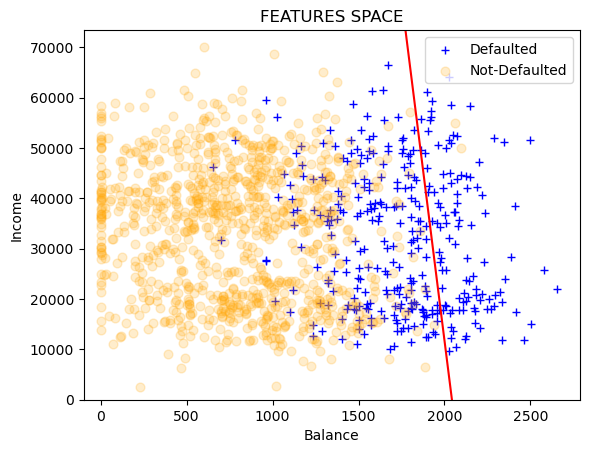

In [57]:
plt.scatter(default_[default_.default == 'Yes'].balance, default_[default_.default == 'Yes'].income, \
    s=40, c='blue', marker='+',linewidths=1, label="Defaulted")

plt.scatter(default_[default_.default == 'No'].balance, default_[default_.default == 'No'].income, \
    s=40, c='orange', marker='o',linewidths=1, alpha=.2,label="Not-Defaulted")

plt.legend()
plt.title('FEATURES SPACE')
plt.ylim(ymin=0)
plt.ylabel('Income')
plt.xlim(xmin=-100)
plt.xlabel('Balance')

plt.plot([x3,x4],[y3,y4], c='red')